In [31]:
!pip install xgboost

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import xgboost as xgb


In [33]:
# Load the data
df = pd.read_csv('Dataset - Project 2.csv')

# Display basic information about the dataset
print(df.info())
print(df.head())

# Basic statistics and distribution of the dataset
print(df.describe())
print(df['Fraud_indicator'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB
None
   Transaction_ID       Timestamp Vehicle_Type         FastagID TollBoo

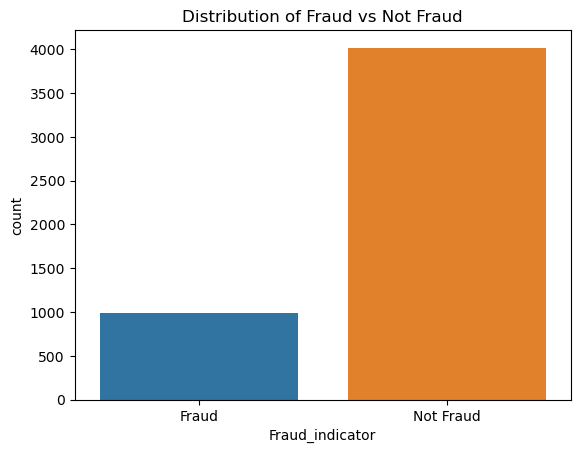

In [34]:
# Visualizing the distribution of Fraud and Not Fraud instances
sns.countplot(x='Fraud_indicator', data=df)
plt.title('Distribution of Fraud vs Not Fraud')
plt.show()


In [35]:
# Fill missing FastagID values with a placeholder
df['FastagID'].fillna('Unknown', inplace=True)

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract useful features from the Timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_features = ['Vehicle_Type', 'Lane_Type', 'Vehicle_Dimensions', 'Geographical_Location', 'Vehicle_Plate_Number', 'FastagID', 'TollBoothID']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
df['Fraud_indicator'] = df['Fraud_indicator'].map({'Fraud': 1, 'Not Fraud': 0})


In [36]:
# Define features and target
X = df.drop(['Transaction_ID', 'Timestamp', 'Fraud_indicator'], axis=1)
y = df['Fraud_indicator']

# Addressing class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [44]:
# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)



# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [45]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nAccuracy Score:')
print(accuracy_score(y_test, y_pred))

print('\nPrecision Score:')
print(precision_score(y_test, y_pred))

print('\nRecall Score:')
print(recall_score(y_test, y_pred))

print('\nF1 Score:')
print(f1_score(y_test, y_pred))


Confusion Matrix:
[[802   0]
 [ 13 792]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       802
           1       1.00      0.98      0.99       805

    accuracy                           0.99      1607
   macro avg       0.99      0.99      0.99      1607
weighted avg       0.99      0.99      0.99      1607


Accuracy Score:
0.9919103920348475

Precision Score:
1.0

Recall Score:
0.9838509316770186

F1 Score:
0.9918597370068879


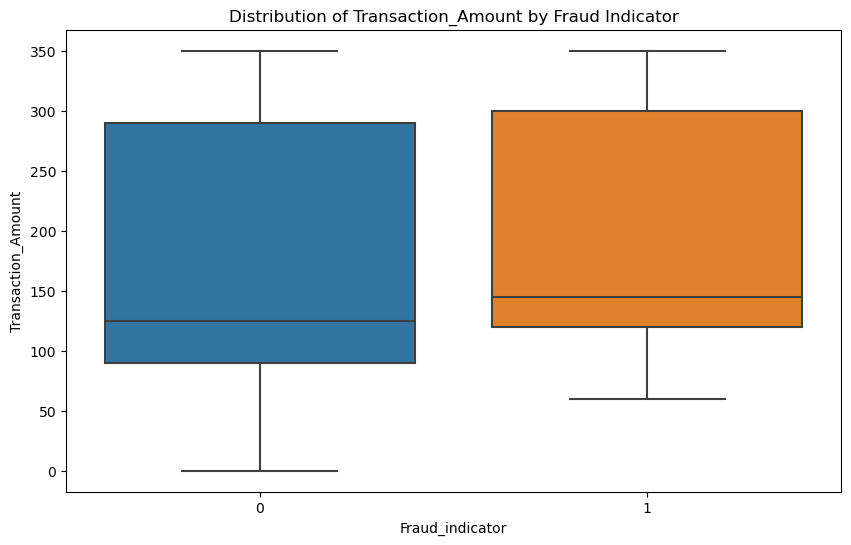

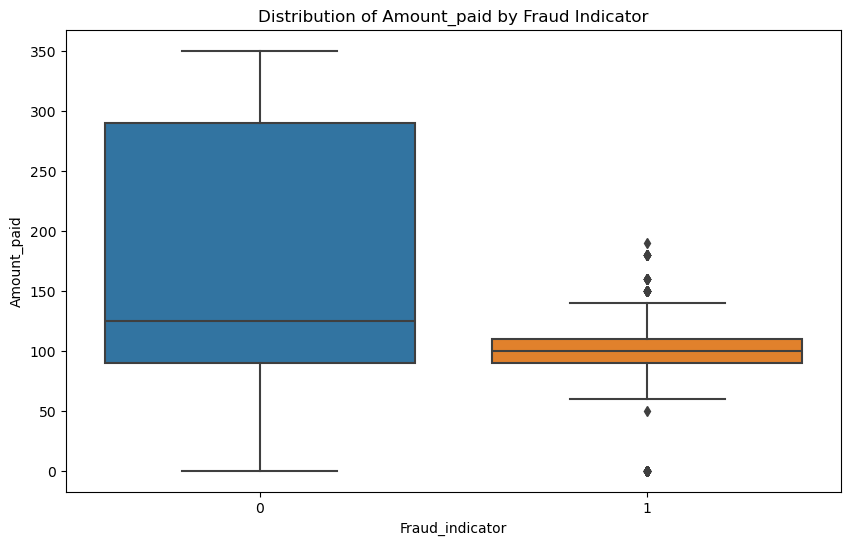

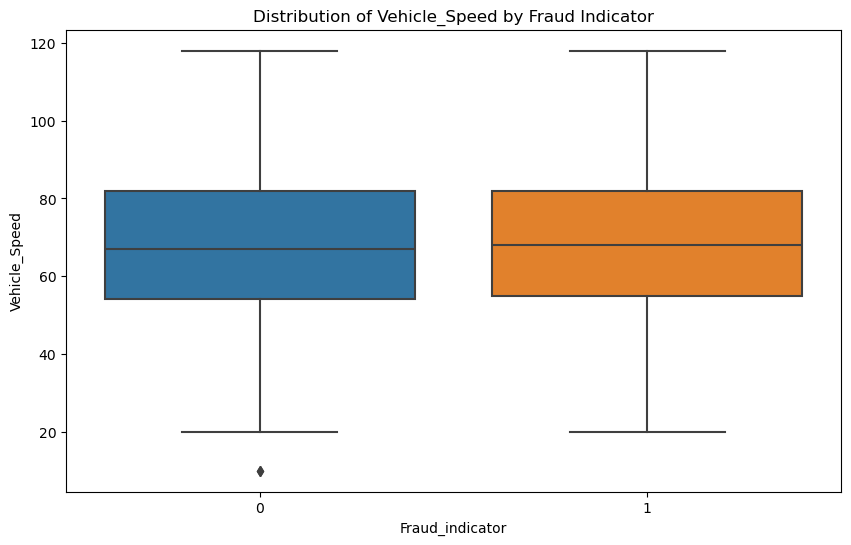

In [46]:
numeric_columns = ['Transaction_Amount', 'Amount_paid', 'Vehicle_Speed']

for col in numeric_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Fraud_indicator', y=col, data=df)
    plt.title(f'Distribution of {col} by Fraud Indicator')
    plt.show()
    


Fraud distribution:
Fraud_indicator
0    80.34
1    19.66
Name: proportion, dtype: float64


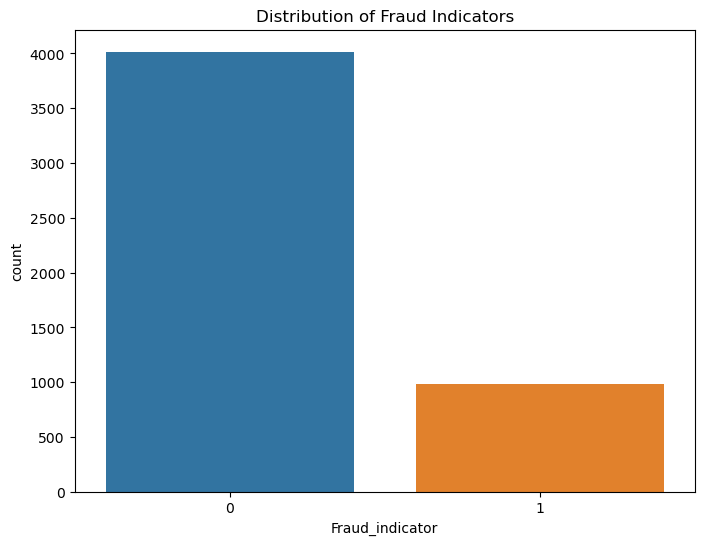

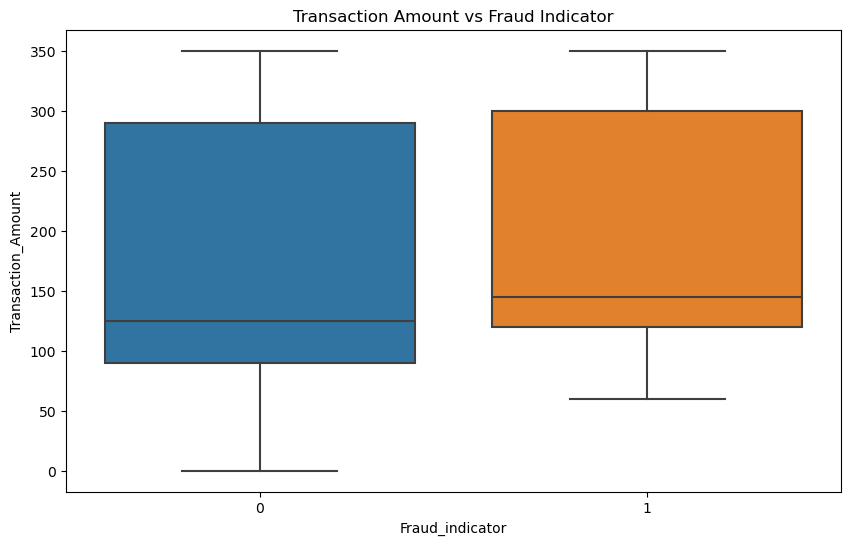

In [47]:
# Analyze the distribution of fraud indicators
fraud_distribution = df['Fraud_indicator'].value_counts(normalize=True) * 100
print("\nFraud distribution:")
print(fraud_distribution)

# Visualize the fraud distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fraud_indicator', data=df)
plt.title('Distribution of Fraud Indicators')
plt.show()

# Analyze the relationship between transaction amount and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud_indicator', y='Transaction_Amount', data=df)
plt.title('Transaction Amount vs Fraud Indicator')
plt.show()

In [52]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [56]:
# Save the trained model to a file
joblib.dump(model, 'fraud_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
best_xgb_model = joblib.load('best_xgb_model.pkl')
scaler = StandardScaler().fit(X_train)  # Assuming you used StandardScaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

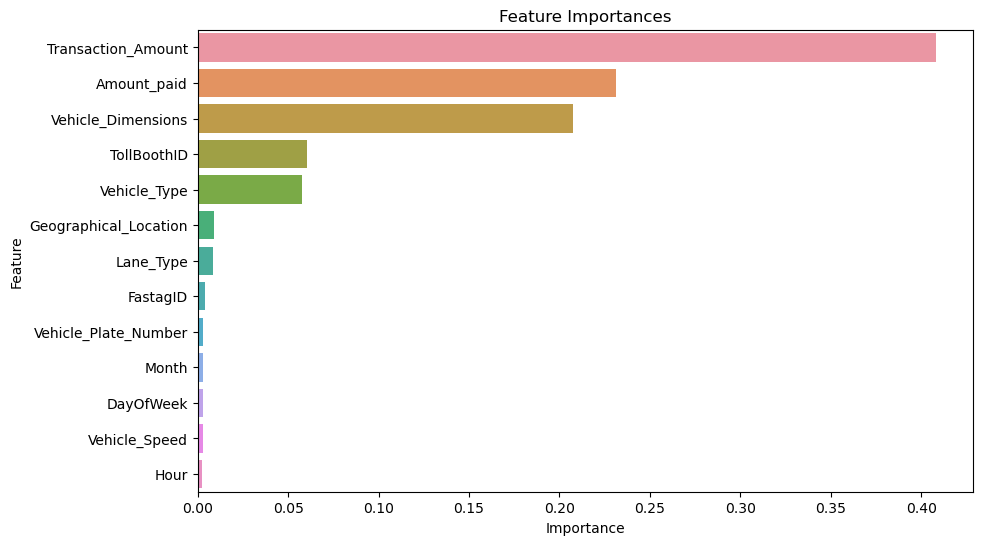

In [54]:
# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


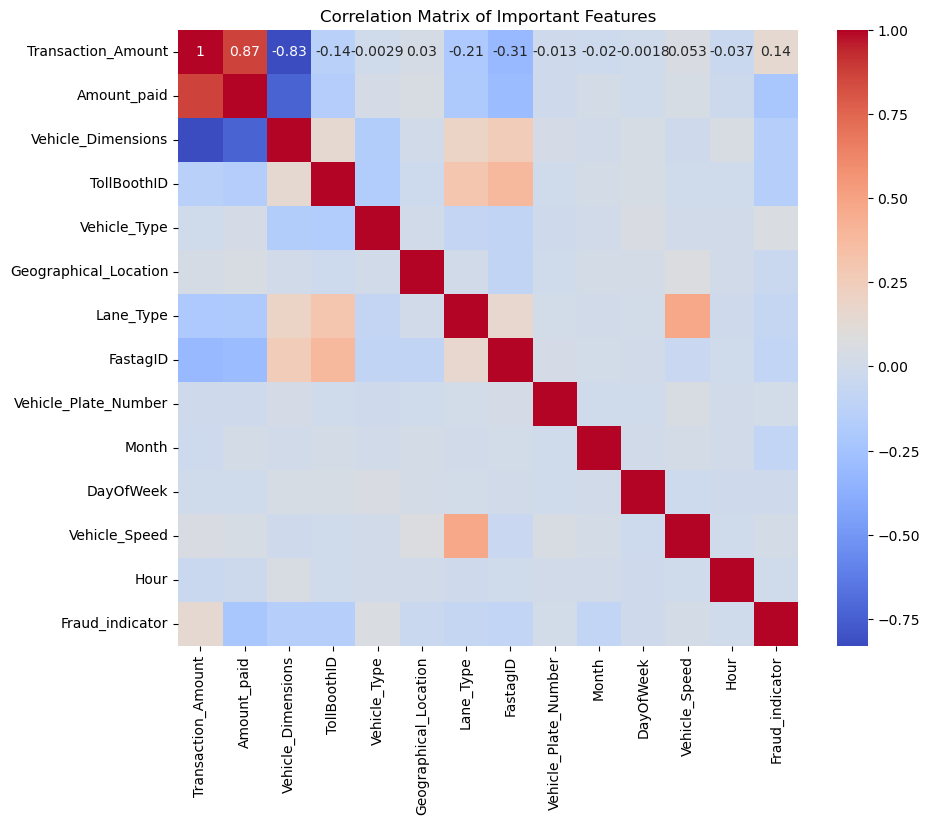

In [55]:
# Assuming `feature_importances` contains the names of features
feature_importances_list = feature_importances['Feature'].tolist()  

# Add 'Fraud_indicator' to the list for correlation analysis
feature_importances_list.append('Fraud_indicator')

# Create correlation matrix
correlation_matrix = df[feature_importances_list].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Important Features')
plt.show()

In [26]:


# Analysis of fraudulent transactions
fraudulent_transactions = df[df['Fraud_indicator'] == 1]
print(fraudulent_transactions.describe())


       Transaction_ID                      Timestamp  Vehicle_Type  \
count      983.000000                            983    983.000000   
mean      2019.330621  2023-05-26 11:39:31.434384384      3.249237   
min          1.000000            2023-01-01 08:15:00      0.000000   
25%        736.500000            2023-02-27 07:25:00      1.000000   
50%       1621.000000            2023-05-03 03:15:00      4.000000   
75%       3343.000000            2023-08-14 19:39:00      5.000000   
max       5000.000000            2023-12-31 21:45:00      6.000000   
std       1494.455295                            NaN      2.126819   

          FastagID  TollBoothID   Lane_Type  Vehicle_Dimensions  \
count   983.000000   983.000000  983.000000          983.000000   
mean   2242.533062     1.050865    0.501526            0.596134   
min       2.000000     0.000000    0.000000            0.000000   
25%    1048.500000     0.000000    0.000000            0.000000   
50%    2195.000000     1.000000   

In [59]:
model = joblib.load('best_xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

def preprocess_data(data):
    # Convert input data to DataFrame
    df = pd.DataFrame(data, index=[0])
    
    # Fill missing FastagID values with a placeholder
    df['FastagID'].fillna('Unknown', inplace=True)

    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Extract useful features from the Timestamp
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['Month'] = df['Timestamp'].dt.month

    # Encode categorical variables
    label_encoder = LabelEncoder()
    categorical_features = ['Vehicle_Type', 'Lane_Type', 'Vehicle_Dimensions', 'Geographical_Location', 'Vehicle_Plate_Number', 'FastagID', 'TollBoothID']
    for feature in categorical_features:
        df[feature] = label_encoder.fit_transform(df[feature])
    
    # Drop unnecessary columns
    df.drop(['Transaction_ID', 'Timestamp'], axis=1, inplace=True)
    
    return df

def predict_fraud(data):
    # Preprocess the input data
    df = preprocess_data(data)
    
    # Scale the features
    X = scaler.transform(df)
    
    # Make predictions
    prediction = model.predict(X)
    
    return prediction[0]

# Example data for prediction
data = {
    'Transaction_ID': 1,
    'Timestamp': '1/6/2023 11:20',
    'Vehicle_Type': 'Bus',
    'FastagID': 'FTG-001-ABC-121',
    'TollBoothID': 'A-101',
    'Lane_Type': 'Express',
    'Vehicle_Dimensions': 'Large',
    'Transaction_Amount': 350,
    'Amount_paid': 120,
    'Geographical_Location': '13.059816123454882, 77.77068662374292',
    'Vehicle_Speed': 65,
    'Vehicle_Plate_Number': 'KA11AB1234'
}


# Perform prediction
prediction = predict_fraud(data)
print(f"Prediction: {'Fraud' if prediction == 1 else 'Not Fraud'}")

Prediction: Not Fraud


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
